<a href="https://colab.research.google.com/github/emircanbacanak/crypto_recommendation/blob/main/crypto_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tulipy


# Gerekli kütüphanlerin importu

In [27]:
import pandas as pd
import numpy as np
import tulipy as ti
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from pycoingecko import CoinGeckoAPI

# Veriyi indir

In [309]:
end = datetime.now().strftime('%Y-%m-%d')
start = datetime.now() - pd.DateOffset(days=30)
data = yf.download("BTC-USD", start=start, end=end, interval="60m")
rsi_period = 7
close_prices = data['Close'].values

# RSI değerlerini hesapla
rsi_values = ti.rsi(close_prices, period=rsi_period)

buy_signal = rsi_values < 36
sell_signal = rsi_values > 75

# Al ve sat sinyallerinin olduğu zamanlardaki indeksleri bul
buy_indices = np.where(buy_signal)[0]
sell_indices = np.where(sell_signal)[0]

[*********************100%%**********************]  1 of 1 completed


# Txt ye kaydet

In [310]:
# Al ve sat sinyallerini birleştir ve sırala
signals = np.sort(np.concatenate((buy_indices, sell_indices)))

correct_signals = []

for i in range(len(signals) - 1):
    # Eğer mevcut sinyal bir alım sinyaliyse
    if signals[i] in buy_indices:
        # Sonraki sinyal bir satım sinyaliyse ve fiyat yükselmişse
        if signals[i+1] in sell_indices and data['Close'].values[signals[i+1]] > data['Close'].values[signals[i]]:
            correct_signals.append(('Alım', signals[i], 'Satış', signals[i+1]))
    # Eğer mevcut sinyal bir satım sinyaliyse
    elif signals[i] in sell_indices:
        # Sonraki sinyal bir alım sinyaliyse ve fiyat düşmüşse
        if signals[i+1] in buy_indices and data['Close'].values[signals[i+1]] < data['Close'].values[signals[i]]:
            correct_signals.append(('Satış', signals[i], 'Alım', signals[i+1]))

# Doğru sinyalleri bir txt dosyasına yaz
output_file = "correct_signals.txt"

with open(output_file, 'w') as f:
    for i, signal in enumerate(correct_signals, 1):
        f.write(f"{i}- {signal[0]} {data.index[signal[1]]}, Fiyat: {data['Close'].values[signal[1]]}\n")
        f.write(f" {signal[2]} {data.index[signal[3]]}, Fiyat: {data['Close'].values[signal[3]]}\n")


# Rsı da al-sat gösterme


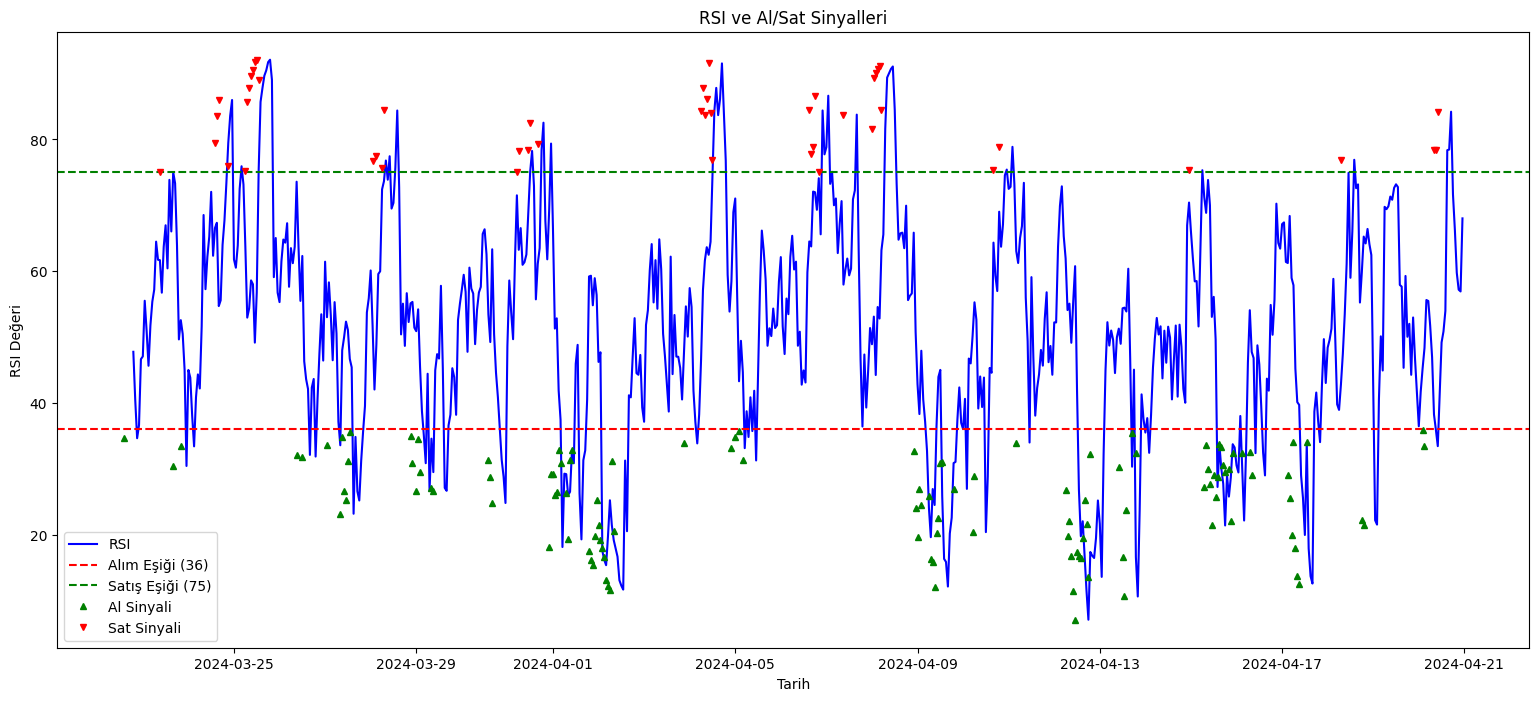

In [314]:


rsi_length = len(rsi_values)

data_length = len(data)

plt.figure(figsize=(19, 8))
plt.plot(data.index[-rsi_length:], rsi_values, label='RSI', color='blue')
plt.axhline(y=36, color='r', linestyle='--', label='Alım Eşiği (36)')
plt.axhline(y=75, color='g', linestyle='--', label='Satış Eşiği (75)')

plt.plot(data.index[buy_indices[-rsi_length:]], rsi_values[buy_indices[-rsi_length:]], '^', markersize=5, color='green', label='Al Sinyali')

plt.plot(data.index[sell_indices[-rsi_length:]], rsi_values[sell_indices[-rsi_length:]], 'v', markersize=5, color='red', label='Sat Sinyali')

plt.title('RSI ve Al/Sat Sinyalleri')
plt.xlabel('Tarih')
plt.ylabel('RSI Değeri')
plt.legend()
plt.show()

# Fiyat'ta Doğru al-sat önerilerini gösterme

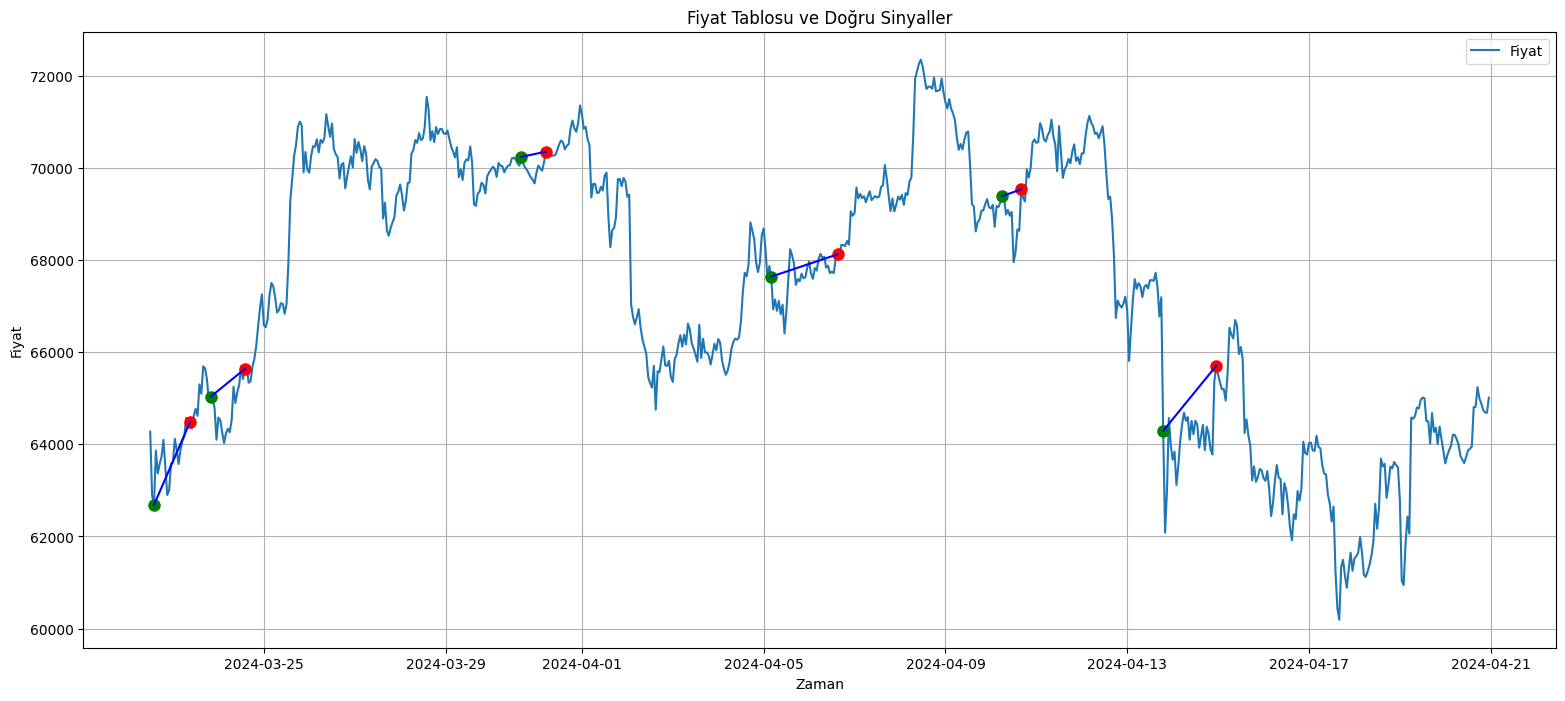

In [373]:
def plot_correct_signals(data, signals, buy_indices, sell_indices):
    # Al ve sat sinyallerini birleştir ve sırala
    signals = np.sort(np.concatenate((buy_indices, sell_indices)))

    correct_signals = []

    for i in range(len(signals) - 1):
        # Eğer mevcut sinyal bir alım sinyaliyse
        if signals[i] in buy_indices:
            # Sonraki sinyal bir satım sinyaliyse ve fiyat yükselmişse
            if signals[i+1] in sell_indices and data['Close'].values[signals[i+1]] > data['Close'].values[signals[i]]:
                correct_signals.append((signals[i], signals[i+1]))
        # Eğer mevcut sinyal bir satım sinyaliyse
        elif signals[i] in sell_indices:
            # Sonraki sinyal bir alım sinyaliyse ve fiyat düşmüşse
            if signals[i+1] in buy_indices and data['Close'].values[signals[i+1]] < data['Close'].values[signals[i]]:
                correct_signals.append((signals[i], signals[i+1]))

    # Fiyat tablosunu çiz
    plt.figure(figsize=(19, 8))
    plt.plot(data.index, data['Close'], label='Fiyat')

    # Doğru sinyalleri işaretle
    for entry, exit in correct_signals:
        plt.plot(data.index[entry], data['Close'].values[entry], 'go' if entry in buy_indices else 'ro', markersize=8)  # Al sinyali yeşil, sat sinyali kırmızı
        plt.plot(data.index[exit], data['Close'].values[exit], 'go' if exit in buy_indices else 'ro', markersize=8)   # Al sinyali yeşil, sat sinyali kırmızı
        plt.plot([data.index[entry], data.index[exit]], [data['Close'].values[entry], data['Close'].values[exit]], 'b-')  # Bağlantı çizgisi

    plt.title('Fiyat Tablosu ve Doğru Sinyaller')
    plt.xlabel('Zaman')
    plt.ylabel('Fiyat')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fonksiyonu kullanarak doğru sinyalleri görselleştir
plot_correct_signals(data, signals, buy_indices, sell_indices)


In [ ]:
!pip install pycoingecko


In [18]:


cg = CoinGeckoAPI()

# Geçmiş verilerin zaman aralığını belirle (son 3 ay)
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=90)

# UNIX zamanına çevir
end_unix = int(end_date.timestamp())
start_unix = int(start_date.timestamp())

# Her günün 12 saatlik verilerini al
for day in range(90):
    # Her günün 12 saatini belirle
    day_start = start_unix + (day * 86400)  # 86400 saniye = 1 gün
    for hour in range(0, 24, 12):  # 12 saatlik aralıklarla
        hour_start = day_start + (hour * 3600)  # 3600 saniye = 1 saat
        hour_end = hour_start + (12 * 3600)  # 12 saatlik aralık

        # Bitcoin fiyat verilerini al
        bitcoin_price_history = cg.get_coin_market_chart_range_by_id(id='bitcoin', vs_currency='usd', from_timestamp=hour_start, to_timestamp=hour_end)

        # Alınan verileri CSV'ye yaz
        with open('bitcoin_price_history.csv', 'a') as f:
            for data in bitcoin_price_history['prices']:
                timestamp = datetime.datetime.fromtimestamp(data[0] / 1000)
                yil_ay_gun = timestamp.strftime('%Y-%m-%d')  # Yıl, ay ve gün bilgisini al
                saat_dakika = timestamp.strftime('%H:%M')  # Saat ve dakika bilgisini al
                price = data[1]
                f.write(f"{yil_ay_gun} {saat_dakika}, {price}\n")


In [39]:
def calculate_rsi(prices, window=14):
    deltas = np.diff(prices)
    seed = deltas[:window+1]
    up = seed[seed >= 0].sum() / window
    down = -seed[seed < 0].sum() / window
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:window] = 100. - 100. / (1. + rs)

    for i in range(window, len(prices)):
        delta = deltas[i - 1]
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (window - 1) + upval) / window
        down = (down * (window - 1) + downval) / window

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)

    return rsi

In [40]:
# Bitcoin fiyat verilerini içeren CSV dosyasını oku
bitcoin_data = pd.read_csv('bitcoin_price_history.csv')

# RSI ve zaman bilgilerini saklamak için boş listeler oluştur
rsi_values = []
timestamps = []

# Bitcoin fiyat verilerinin olduğu sütunu belirle
price_column = bitcoin_data.columns[1]  # İkinci sütun fiyat bilgisini içeriyor

for index, row in bitcoin_data.iterrows():
    # Tarih, saat ve dakika bilgisini al
    date_info = row[0]  # İlk sütun tarih, saat ve dakika bilgisini içeriyor
    date_time = datetime.datetime.strptime(date_info, '%Y-%m-%d %H:%M')

    # Bitcoin fiyat verisini al
    price = row[price_column]

    # RSI değerini hesapla
    prices = bitcoin_data[price_column].values[:index+1]  # Şu anki fiyat hariç tüm fiyat verilerini al
    rsi = calculate_rsi(prices)

    # RSI değerlerini ve zaman bilgilerini listelere ekle
    timestamps.append(date_time)
    rsi_values.append(rsi[-1])  # Son RSI değerini al (en son hesaplanan)

# RSI değerlerini ve zaman bilgilerini içeren DataFrame'i oluştur
df = pd.DataFrame({'Timestamp': timestamps, 'RSI': rsi_values})

# DataFrame'i CSV dosyasına kaydet
df.to_csv('bitcoin_rsi_values.csv', index=False)

<ipython-input-39-69fcd0257440>:6: RuntimeWarning: invalid value encountered in scalar divide
  rs = up / down
<ipython-input-39-69fcd0257440>:6: RuntimeWarning: divide by zero encountered in scalar divide
  rs = up / down
